# Preparing Data

In [ ]:
import sys
import os
import glob
import pandas as pd

sys.path.append(os.path.abspath(os.path.join('../../..')))

In [ ]:
from src.etl.bronze.extract.data_structure_extract_strategy import DataExtractor
import src.etl.transform.data_cleansing_strategy as BaseCleansing
import src.etl.transform.data_transform_strategy as BaseTransform
import src.analysis.visualization.data_univariate_visualization_strategy as BaseViz
import src.etl.transform.data_encoding_strategy as BaseEncoder

In [3]:
pattern = os.path.join(os.path.abspath(os.path.join('../../..', 
                                                    'data', 
                                                    'interim',
                                                    'data_news_segmentation',
                                                    'description_null')), 
                                                    "newsseg_desc_null_v*.csv")
files = glob.glob(pattern)
if files:
    latest_file = max(files)
else:
    latest_file = None

Extractor_csv = DataExtractor.get_extractor(cfg={
    "type": "csv",
    "path": latest_file ,
    })
df = Extractor_csv.extractor()
df.head()

,title,description,categories
0,nba draft player survey: who's the most underr...,cooper flagg's energy and leadership are the b...,sport
1,£250million chelsea manor's owner says 'britai...,the luxury 300-year-old georgian manor belongi...,sport
2,'guardians of the galaxy' star says her oscar ...,oscar-winner zoe saldaña told people magazine ...,entertainment
3,atlanta’s growth streak has come to an end - t...,NaN,business
4,exempting tips from taxes could hurt employees...,lawmakers recently passed measures to exempt t...,business


In [4]:
encoder_strategies = [
    BaseEncoder.LabelColumnsEncoder(columns=['categories'])
]

cleansing_strategies = [
    BaseCleansing.DropColumnsCleansing(columns=[
        'description',
        #'categories'
    ])
]

transform_strategies = [
    BaseTransform.AstypeTransform(dtype_map={
        'title': 'string',
        'categories': 'category',
    })
]


cleansing = BaseCleansing.DataCleansing(cleansing_strategies)
transform= BaseTransform.DataTransform(transform_strategies)
encoder = BaseEncoder.DataEncoder(encoder_strategies)

df = encoder.encode(df)
df = cleansing.clean(df)
df = transform.transform(df)
df.head()


Mapping for categories: {'business': 0, 'entertainment': 1, 'general': 2, 'health': 3, 'politics': 4, 'science': 5, 'sport': 6, 'tech': 7}
----------------------------------------
Dropping columns: ['description']
----------------------------------------
Changing column 'title' to string ...
Changing column 'categories' to category ...
----------------------------------------


,title,categories,encoded_categories
0,nba draft player survey: who's the most underr...,sport,6
1,£250million chelsea manor's owner says 'britai...,sport,6
2,'guardians of the galaxy' star says her oscar ...,entertainment,1
3,atlanta’s growth streak has come to an end - t...,business,0
4,exempting tips from taxes could hurt employees...,business,0


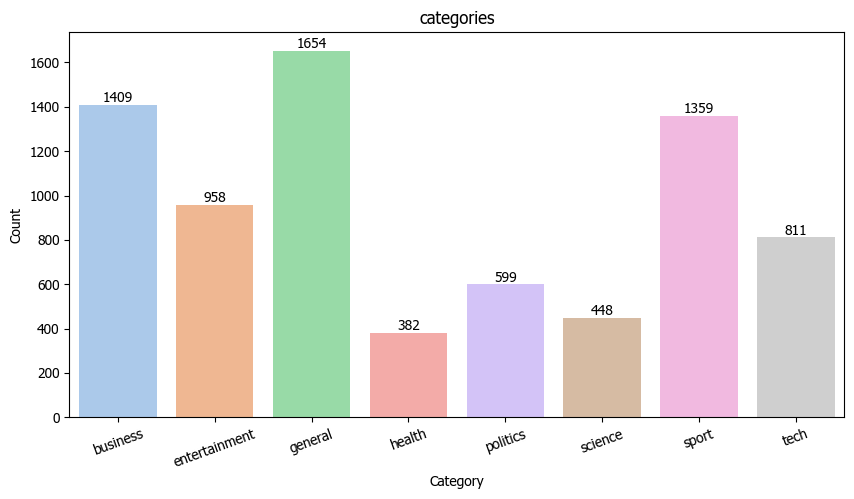

----------------------------------------


In [5]:
strategies_viz = [
    BaseViz.BarplotUniViz(
        sns_kwargs={"palette": "pastel", "hue": "category", "legend": False},
        plt_kwargs={"figsize": (10, 5), "title": 'categories', "rotation": 20, "fontsize":10}
        )
]
viz = BaseViz.UniVisualizer(strategies_viz)
viz.visualize(df,'categories')

# Segmentation

## TFID

In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

In [7]:
text_tfid = df.title

cv = CountVectorizer()
# cv = CountVectorizer(stop_words='english')
count_matrix_tfid = cv.fit_transform(text_tfid)

word_matrix_tfid = count_matrix_tfid.toarray()

df_word_tfid = pd.DataFrame(word_matrix_tfid, columns=cv.get_feature_names_out())

dfsum_tfid = df_word_tfid.sum(axis=0,skipna=True).sort_values(ascending=False)[:30]

dfsum_tfid


the     51243
to      25293
of      20160
and     18379
in      18200
for      9196
is       8422
that     7870
on       7832
it       7681
said     6931
was      5842
he       5784
be       5611
with     5484
as       5060
has      4869
at       4771
have     4594
by       4537
but      4335
will     4308
are      4244
from     3610
not      3425
his      3002
we       2953
they     2944
mr       2861
this     2788
dtype: int64

In [8]:
vectorizer = TfidfVectorizer(

    # ngram_range=(1, 2),
    # min_df=0.01,
    # max_df=0.9,
    stop_words='english'
)
X = vectorizer.fit_transform(df.title)
df_T = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out(), index=df.index)
df_T.shape


(7620, 37305)